<a href="https://colab.research.google.com/github/sambatawa/Terra-Sm5Pro/blob/ml/notebooks/modelTerra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download dataset dari Roboflow

In [35]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yEPtugH4dS6UzzWA1pLZ")
project = rf.workspace("haha-bgzom").project("terra-kwpba")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to terra-1 in yolov8:: 100%|██████████| 2028/2028 [00:00<00:00, 4018.12it/s]


Preprocessing Data

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00


In [36]:
from ultralytics import YOLO
import os
from PIL import Image, ImageOps
from tqdm import tqdm
import shutil

In [33]:
apro_folder = "terra-1/preprocessed"
shutil.rmtree(apro_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'terra-1/preprocessed'

In [37]:
def preprocess_images(input_folder, output_folder, size=(640, 640)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_name in tqdm(os.listdir(input_folder)):
        if img_name.lower().endswith(("jpg", "jpeg", "png")):
            img_path = os.path.join(input_folder, img_name)

            img = Image.open(img_path)
            img = ImageOps.exif_transpose(img)
            img = img.resize(size)

            img.save(os.path.join(output_folder, img_name))


In [38]:
def copy_labels(src_folder, dst_folder):
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)
    for lbl in os.listdir(src_folder):
        if lbl.endswith(".txt"):
            shutil.copy(
                os.path.join(src_folder, lbl),
                os.path.join(dst_folder, lbl)
    )

In [44]:
base = "terra-1"
splits = ["train", "valid", "test"]

for split in splits:
    img_in = os.path.join(base, split, "images")
    lbl_in = os.path.join(base, split, "labels")

    img_out = os.path.join(base, "preprocessed", split, "images")
    lbl_out = os.path.join(base, "preprocessed", split, "labels")

    print(f"Processing {split}...")
    preprocess_images(img_in, img_out, size=(640, 640))
    copy_labels(lbl_in, lbl_out)

print("Preprocessing selesai.")

Processing train...


100%|██████████| 706/706 [00:12<00:00, 57.62it/s]


Processing valid...


100%|██████████| 201/201 [00:03<00:00, 56.28it/s]


Processing test...


100%|██████████| 101/101 [00:01<00:00, 61.75it/s]

Preprocessing selesai.


Augmentasi Data

In [45]:
!pip install albumentations

In [55]:
aug_folder = "terra-1/augmented"
shutil.rmtree(aug_folder)

In [46]:
import cv2 as cv
import albumentations as A

In [56]:
transform = A.Compose([
                       A.RandomBrightnessContrast(p=0.7),
                       A.HorizontalFlip(p=0.5),
                       A.RandomScale(scale_limit=0.1, p=0.5),
                    ], bbox_params=A.BboxParams(
                      format='yolo',
                      label_fields=['class_labels'],
                      min_area=0.0001,
                      min_visibility=0.1,
))

In [57]:
def clip_bboxes_yolo(bboxes, class_labels=None):
    clipped = []
    kept_labels = [] if class_labels is not None else None
    for idx, (x, y, w, h) in enumerate(bboxes):
        half_w = w / 2
        half_h = h / 2
        x_min = max(x - half_w, 0.0)
        y_min = max(y - half_h, 0.0)
        x_max = min(x + half_w, 1.0)
        y_max = min(y + half_h, 1.0)
        new_w = x_max - x_min
        new_h = y_max - y_min

        if new_w <= 0 or new_h <= 0:
            continue

        new_x = x_min + new_w / 2
        new_y = y_min + new_h / 2
        clipped.append([new_x, new_y, new_w, new_h])

        if kept_labels is not None:
            kept_labels.append(class_labels[idx])

    if kept_labels is None:
        return clipped
    return clipped, kept_labels


In [58]:
def augment_dataset(img_folder, lbl_folder, out_img, out_lbl, aug_per_image=1):
    os.makedirs(out_img, exist_ok=True)
    os.makedirs(out_lbl, exist_ok=True)

    image_files = [f for f in os.listdir(img_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    for img_name in tqdm(image_files):
        img_path = os.path.join(img_folder, img_name)
        base_name, img_ext = os.path.splitext(img_name)
        lbl_path = os.path.join(lbl_folder, f"{base_name}.txt")

        img = cv.imread(img_path)
        if img is None:
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        bboxes = []
        class_labels = []
        if os.path.exists(lbl_path):
            with open(lbl_path, "r") as f:
                for line in f.readlines():
                    cls, x, y, w, h = line.strip().split()
                    bboxes.append([float(x), float(y), float(w), float(h)])
                    class_labels.append(int(cls))
        bboxes, class_labels = clip_bboxes_yolo(bboxes, class_labels)

        if not bboxes:
            continue

        for i in range(aug_per_image):
            augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            aug_img = augmented["image"]
            aug_boxes, aug_labels = clip_bboxes_yolo(augmented["bboxes"], augmented["class_labels"])
            if not aug_boxes:
                continue

            new_img_name = f"{base_name}_aug{i}{img_ext}"
            new_lbl_name = f"{base_name}_aug{i}.txt"

            cv.imwrite(os.path.join(out_img, new_img_name), cv.cvtColor(aug_img, cv.COLOR_RGB2BGR))

            with open(os.path.join(out_lbl, new_lbl_name), "w") as f:
                for cls, (x, y, w, h) in zip(aug_labels, aug_boxes):
                    f.write(f"{cls} {x} {y} {w} {h}\n")


In [59]:
img_in = "terra-1/preprocessed/train/images"
lbl_in = "terra-1/preprocessed/train/labels"

img_out = "terra-1/augmented/images"
lbl_out = "terra-1/augmented/labels"

augment_dataset(img_in, lbl_in, img_out, lbl_out, aug_per_image=2)

100%|██████████| 706/706 [00:07<00:00, 92.96it/s]


Pengecekkan hasil processing->augmentasi


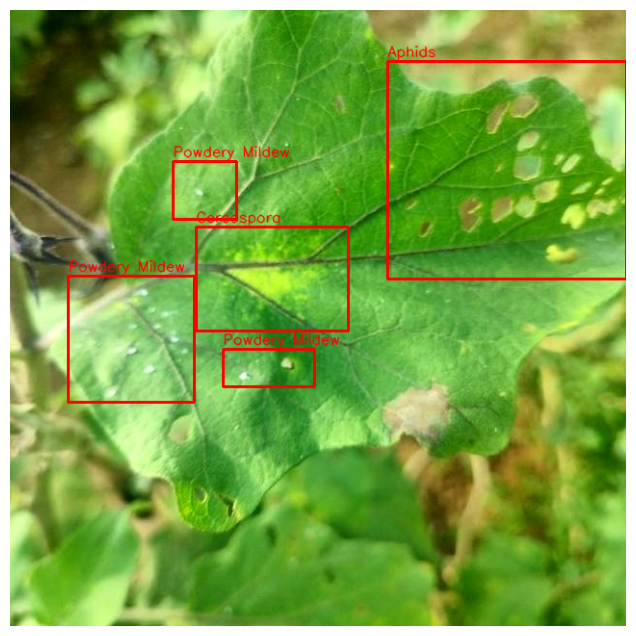

In [60]:
import cv2
import matplotlib.pyplot as plt

class_names = ["Aphids", "Cercospora", "Leaf Wilt", "Phytophthora Blight", "Powdery Mildew", "Sehat", "TMV"]
img_path = "/content/terra-1/augmented/images/Aphids_original0049_jpg.rf.aa80f8d5a950d28e44c82d9d50ab037c_aug0.jpg"
lbl_path = "/content/terra-1/augmented/labels/Aphids_original0049_jpg.rf.aa80f8d5a950d28e44c82d9d50ab037c_aug0.txt"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(lbl_path) as f:
    for line in f.readlines():
        cls, x, y, w, h = map(float, line.strip().split())
        img_h, img_w, _ = img.shape

        x1 = int((x - w/2) * img_w)
        y1 = int((y - h/2) * img_h)
        x2 = int((x + w/2) * img_w)
        y2 = int((y + h/2) * img_h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

        label = class_names[int(cls)]
        cv2.putText(img, label, (x1, max(y1-5,0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1, cv2.LINE_AA)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.show()


Model

Pretrained with default backbone YOLOv8

In [66]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

In [68]:
folder = "yolo11n.pt"
shutil.rmtree(folder)

NotADirectoryError: [Errno 20] Not a directory: 'yolo11n.pt'

In [67]:
hasil = model.train(data="/content/terra-1/data.yaml", epochs=100, batch=16)

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/terra-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

In [ ]:
hasil = model.train(data="/content/terra-1/data.yaml", epochs=100, batch=32)

In [ ]:
model = YOLO("best.pt")
hasil = model.predict(source="/content/terra-1/preprocessed/test/images", save=True)

In [ ]:
for hasil in h:
  pass

In [ ]:
metrics = model.val(data="/content/terra-1/data.yaml")
print("mAP50-95:", metrics.box.map)
print("mAP50:", metrics.box.map50)
print("mAP75:", metrics.box.map75)
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)

In [ ]:
Image.open("runs/detect/train/confusion_matrix.png").resize((600,600))

In [ ]:
Image.open("runs/detect/train/results.png").resize((1000,500))

In [ ]:
Image.open("runs/detect/train/train_batch1.jpg").resize((1000,500))

In [ ]:
Image.open("runs/detect/train/F1_curve.png").resize((600,600))

In [ ]:
Image.open("runs/detect/train/PR_curve.png").resize((600,600))

In [ ]:
from ultralytics import YOLO
model = YOLO("runs/detect/train/weights/best.pt")
model.export(format="onnx", opset=12, imgsz=640, simplify=True)